In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.mlab import griddata

In [2]:
import keras.backend as K
from keras.models import Model
from keras.layers import Input, Dense
from keras.optimizers import Adam
from keras.utils import to_categorical

Using TensorFlow backend.


In [3]:
# prepare the data
n_samples = 50000

In [4]:
def prepare_data(n_samples):
    data = []
    labels = []
    nuisances = []
    
    for i in range(n_samples):
        sig_bkg = np.random.uniform(low = 0.0, high = 1.0, size = 1)
        if sig_bkg > 0.5:
            data.append(np.random.multivariate_normal(mean = [0.0, 0.0], cov = 0.01 * np.array([[1, -0.5], [-0.5, 1]]), size = 1).flatten())
            labels.append(1.0)
            nuisances.append(0.0)
        else:
            #nuisance = np.random.uniform(low = 0.0, high = 2.0, size = 1)
            nuisance = np.random.choice(3, 1)[0]
            data.append(np.random.multivariate_normal(mean = [1.0, nuisance], cov = 0.01 * np.eye(2), size = 1).flatten())
            labels.append(0.0)
            nuisances.append(nuisance + 1)
            
    data = np.array(data)
    labels = np.array(labels)
    nuisances = np.array(nuisances)
    
    return data, labels, nuisances

In [5]:
data_train, poi, nuisances_train = prepare_data(n_samples)

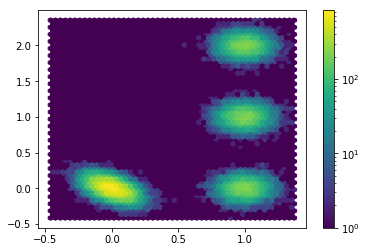

In [6]:
plt.hexbin(x = data_train[:, 0], y = data_train[:, 1], bins = 'log', gridsize = 50)
plt.colorbar()
plt.show()

In [7]:
# define the models
def build_encoder(inputs):
    lay = Dense(20, activation = "relu")(inputs)
    #lay = Dense(20, activation = "relu")(lay)
    outputs = Dense(2, activation = "linear", name = 'encoder_output')(lay)
    
    encoder = Model(inputs = [inputs], outputs = [outputs])
    return encoder

def build_decoder_nuisance(inputs):
    lay = Dense(20, activation = "relu")(inputs)
    #lay = Dense(20, activation = "relu")(lay)
    outputs = Dense(4, activation = "softmax", name = 'decoder_nuisance_output')(lay)
    
    decoder_nuisance = Model(inputs = [inputs], outputs = [outputs])
    return decoder_nuisance

def build_decoder_poi(inputs):
    lay = Dense(20, activation = "relu")(inputs)
    #lay = Dense(20, activation = "relu")(lay)
    outputs = Dense(2, activation = "softmax", name = 'decoder_poi_output')(lay)
    
    decoder_poi = Model(inputs = [inputs], outputs = [outputs])
    return decoder_poi

In [227]:
decoder_nuisance_input = Input(shape = (2,), name = 'decoder_nuisance_input')
decoder_nuisance = build_decoder_nuisance(decoder_nuisance_input)
decoder_nuisance_opt = Adam(lr = 0.0005, beta_1 = 0.5, beta_2 = 0.999, epsilon = K.epsilon(), decay = 0.0)
decoder_nuisance.compile(loss = 'categorical_crossentropy',
                        optimizer = decoder_nuisance_opt,
                        metrics = [])

In [228]:
decoder_poi_input = Input(shape = (2,), name = 'decoder_poi_input')
decoder_poi = build_decoder_poi(decoder_poi_input)
decoder_poi_opt = Adam(lr = 0.0005, beta_1 = 0.5, beta_2 = 0.999, epsilon = K.epsilon(), decay = 0.0)
decoder_poi.compile(loss = 'categorical_crossentropy',
                        optimizer = decoder_poi_opt,
                        metrics = [])

In [229]:
decoder_nuisance.trainable = False
decoder_poi.trainable = False

encoder_inputs = Input(shape = (2,), name = 'encoder_inputs')
encoder = build_encoder(encoder_inputs)
encoder_opt = Adam(lr = 0.0005, beta_1 = 0.5, beta_2 = 0.999, epsilon = K.epsilon(), decay = 0.0)
encoder.compile(loss = 'categorical_crossentropy',
                   optimizer = encoder_opt,
                   metrics = [])

adv_opt = Adam(lr = 0.0002, beta_1 = 0.5, beta_2 = 0.999, epsilon = K.epsilon(), decay = 0.0)
adv = Model(inputs = [encoder_inputs], outputs = [decoder_nuisance(encoder(encoder_inputs)), decoder_poi(encoder(encoder_inputs))]) 

adv.compile(loss = ['categorical_crossentropy', 'categorical_crossentropy'], loss_weights = [-0.1, 1.0],
           optimizer = adv_opt,
           metrics = [])

In [182]:
number_epochs = 10
batch_size = 30
train_multiplicity = {"decoder_poi": 2, "decoder_nuisance": 2, "encoder": 3}

In [266]:
for i in range(number_epochs):
    for i_decoder_poi in range(train_multiplicity["decoder_nuisance"]):
        inds = np.random.choice(len(data_train), batch_size)
        data_batch = data_train[inds]
        poi_batch = to_categorical(poi[inds], num_classes = 2)
        encodings = encoder.predict(data_batch)
        loss = decoder_poi.train_on_batch(encodings, poi_batch)
    print("decoder_poi_loss = {}".format(loss))
    
    for i_decoder_nuisance in range(train_multiplicity["decoder_poi"]):
        inds = np.random.choice(len(data_train), batch_size)
        data_batch = data_train[inds]
        nuisances_batch = to_categorical(nuisances_train[inds], num_classes = 4)
        encodings = encoder.predict(data_batch)
        loss = decoder_nuisance.train_on_batch(encodings, nuisances_batch)
    print("decoder_nuisance_loss = {}".format(loss))
    
    for i_encoder in range(train_multiplicity["encoder"]):
        inds = np.random.choice(len(data_train), batch_size)
        data_batch = data_train[inds]
        nuisances_batch = to_categorical(nuisances_train[inds], num_classes = 4)
        poi_batch = to_categorical(poi[inds], num_classes = 2)
        loss = adv.train_on_batch(data_batch, [nuisances_batch, poi_batch])
    print("encoder_loss = {}".format(loss))

decoder_poi_loss = 0.09329594671726227
decoder_nuisance_loss = 0.7322921752929688
encoder_loss = [0.010218948, 1.0870636, 0.1189253]
decoder_poi_loss = 0.07620815932750702
decoder_nuisance_loss = 0.7357289791107178
encoder_loss = [0.014956132, 0.6262254, 0.07757867]
decoder_poi_loss = 0.07140099257230759
decoder_nuisance_loss = 0.6561650633811951
encoder_loss = [0.0183243, 0.7195357, 0.09027787]
decoder_poi_loss = 0.07491523772478104
decoder_nuisance_loss = 0.7071290612220764
encoder_loss = [0.014731489, 0.6374442, 0.07847591]
decoder_poi_loss = 0.05865589529275894
decoder_nuisance_loss = 0.6579671502113342
encoder_loss = [-0.007612765, 0.8192028, 0.074307516]
decoder_poi_loss = 0.07787562906742096
decoder_nuisance_loss = 0.6316502690315247
encoder_loss = [0.03602207, 0.5349703, 0.0895191]
decoder_poi_loss = 0.08035736531019211
decoder_nuisance_loss = 0.6807934045791626
encoder_loss = [0.003881164, 0.76267976, 0.080149144]
decoder_poi_loss = 0.09053720533847809
decoder_nuisance_loss = 

/home/philipp/.local/lib/python3.5/site-packages/keras/engine/training.py:479: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


In [184]:
# prepare test data
data_test = np.random.uniform(low = -1, high = 2, size = [50000, 2])

In [267]:
pred_poi = decoder_poi.predict(data_test)

/usr/lib/python3/dist-packages/ipykernel/__main__.py:4: MatplotlibDeprecationWarning: The griddata function was deprecated in Matplotlib 2.2 and will be removed in 3.1. Use scipy.interpolate.griddata instead.
/home/philipp/.local/lib/python3.5/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'interp'
  s)


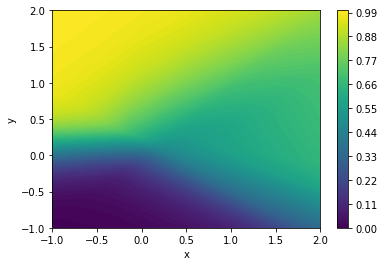

In [268]:
# plot a contour map
xi = np.linspace(-1, 2, 1000)
yi = np.linspace(-1, 2, 1000)
zi = griddata(data_test[:, 0], data_test[:, 1], pred_poi[:, 0], xi, yi, interp = "linear")

plt.contourf(xi, yi, zi, interp='linear', levels = 100)
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()
plt.show()

In [166]:
# look for pivoting
data_test, poi_test, nuisances_test = prepare_data(n_samples)

In [269]:
data1 = data_test[nuisances_test == 1]
data2 = data_test[nuisances_test == 2]
data3 = data_test[nuisances_test == 3]

In [270]:
pred1 = decoder_poi.predict(data1)
pred2 = decoder_poi.predict(data2)
pred3 = decoder_poi.predict(data3)

In [223]:
data0 = data_test[nuisances_test == 0]

In [272]:
pred0 = decoder_poi.predict(data0)

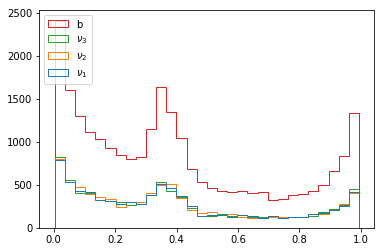

In [274]:
colors = ['red', 'tan', 'lime', 'green']
plt.hist([pred1[:,1], pred2[:,1], pred3[:,1], pred0[:,1]], label = [r'$\nu_1$', r'$\nu_2$', r'$\nu_3$', 'b'], histtype = 'step', stacked = False, fill = False, bins = 30)
plt.legend(loc = 'upper left')
plt.show()